In [16]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np
import matplotlib.pyplot as plt


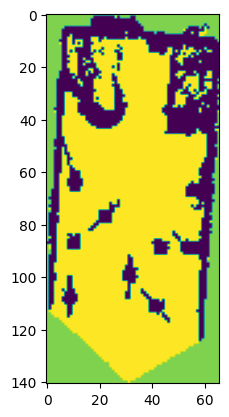

In [3]:
def read_pgm(path):
    with open(path, 'rb') as pgmf:
        im = plt.imread(pgmf)
    return im


path = "/home/william/data/cybathlon/test.pgm"
mat = read_pgm(path)
plt.figure()
plt.imshow(mat)
plt.show()

In [8]:
val, cnt = np.unique(mat, return_counts=True)
print(val)
print(cnt)

# 254: walkable area
# 0: obstacles
# 205: undiscovered area

[  0 205 254]
[2161 1740 5405]


In [14]:
# get coordinates
obstacles = np.where(mat==0)
walkable = np.where(mat==254)
undiscovered = np.where(mat==205)


In [19]:
np.array(obstacles)

array([[  1,   1,   1, ..., 123, 123, 124],
       [ 18,  19,  20, ...,  58,  59,  58]])

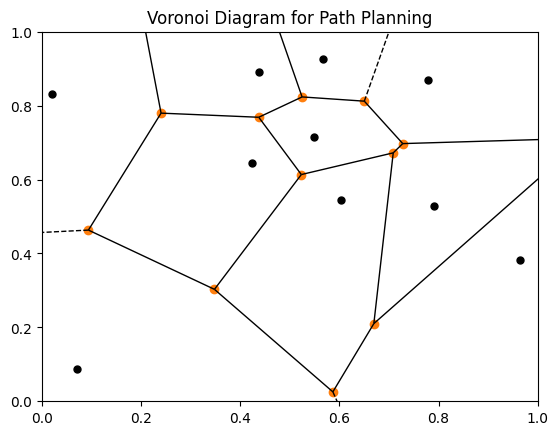

In [9]:
from scipy.spatial import Voronoi, voronoi_plot_2d

# Number of obstacles
num_obstacles = 10

# Generate random obstacle locations
np.random.seed(0)
obstacles = np.random.rand(num_obstacles, 2)  # 2D coordinates

# Create the Voronoi diagram for the obstacles
vor = Voronoi(obstacles)

# Plot the Voronoi diagram
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax)

# Plot the obstacles
ax.plot(obstacles[:, 0], obstacles[:, 1], 'ko', markersize=5)

# Customize plot
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('Voronoi Diagram for Path Planning')
plt.show()

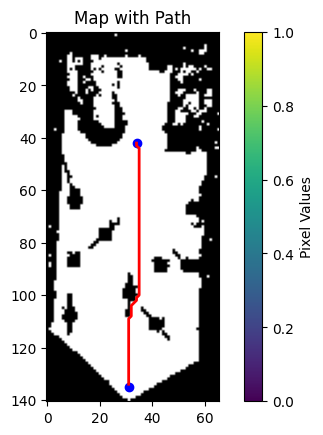

In [21]:
from scipy.spatial import distance
import heapq

def heuristic(a, b):
    """Calculate the heuristic distance between two points (Euclidean distance)."""
    return distance.euclidean(a, b)

def astar(array, start, goal):
    """Perform A* algorithm on a grid."""
    neighbors = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]

    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, goal)}
    open_set = []

    heapq.heappush(open_set, (fscore[start], start))
    
    while open_set:
        current = heapq.heappop(open_set)[1]

        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:                
                    if array[neighbor[0]][neighbor[1]] == 0:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in open_set]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(open_set, (fscore[neighbor], neighbor))
                
    return False

# Define start and goal points
start_point = (135, 31)  # y, x as numpy arrays are row-major
goal_point = (42, 34)    # y, x

# Preprocess the map: walkable areas (254), obstacles (0), boundaries (205)
# For path planning, treat non-walkable (0 and 205) as obstacles
walkable_map = np.where(mat == 254, 1, 0)

# Apply A* algorithm
path = astar(walkable_map, start_point, goal_point)

# Display the map and the path
plt.imshow(walkable_map, cmap='gray')
if path:
    y, x = zip(*path)
    plt.plot(x, y, color='red', linewidth=2)
    plt.scatter([start_point[1], goal_point[1]], [start_point[0], goal_point[0]], color='blue')
else:
    print("Path not found")

plt.colorbar(label='Pixel Values')
plt.title('Map with Path')
plt.show()



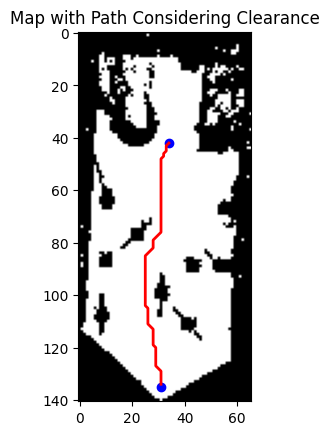

In [31]:
def is_clear_of_obstacles(point, clearance, obstacle_map):
    """ Check if a point has the required clearance from obstacles. """
    y, x = point
    y_min, y_max = max(0, y - clearance), min(obstacle_map.shape[0], y + clearance + 1)
    x_min, x_max = max(0, x - clearance), min(obstacle_map.shape[1], x + clearance + 1)
    return np.all(obstacle_map[y_min:y_max, x_min:x_max] == 1)

def astar_with_clearance(array, start, goal, clearance):
    """ A* algorithm with clearance constraint. """
    neighbors = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]

    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, goal)}
    open_set = []

    heapq.heappush(open_set, (fscore[start], start))
    
    while open_set:
        current = heapq.heappop(open_set)[1]

        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)

            if 0 <= neighbor[0] < array.shape[0] and 0 <= neighbor[1] < array.shape[1]:
                if is_clear_of_obstacles(neighbor, clearance, array):
                    if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                        continue
                    
                    if tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1] for i in open_set]:
                        came_from[neighbor] = current
                        gscore[neighbor] = tentative_g_score
                        fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                        heapq.heappush(open_set, (fscore[neighbor], neighbor))
                else:
                    # Neighbor is too close to an obstacle
                    continue
            else:
                # Neighbor is out of map bounds
                continue
                
    return False

# Define start and goal points
start_point_updated = (135, 31)  # y, x as numpy arrays are row-major
goal_point_updated = (42, 34)    # y, x

# Apply A* algorithm with clearance constraint
clearance_required = 3  # 16 pixels clearance
path_with_clearance = astar_with_clearance(walkable_map, start_point_updated, goal_point_updated, clearance_required)

# Display the map and the path
plt.imshow(walkable_map, cmap='gray')
if path_with_clearance:
    y, x = zip(*path_with_clearance)
    plt.plot(x, y, color='red', linewidth=2)
    plt.scatter([start_point_updated[1], goal_point_updated[1]], [start_point_updated[0], goal_point_updated[0]], color='blue')
else:
    print("Path not found")

plt.title('Map with Path Considering Clearance')
plt.show()



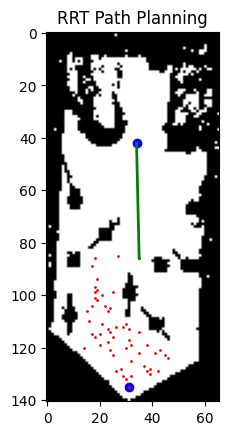

'Path to goal found.'

In [34]:
import random

def nearest_node(tree, point):
    """ Find the nearest node in the tree to the given point. """
    return min(tree, key=lambda x: distance.euclidean(x, point))

def is_collision_free(new_point, nearest_point, obstacle_map, clearance):
    """ Check if the path between two points is collision-free and maintains clearance. """
    y0, x0 = nearest_point
    y1, x1 = new_point
    if x0 == x1 or y0 == y1:
        return False
    y, x = np.ogrid[y0:y1:np.sign(y1-y0)*1, x0:x1:np.sign(x1-x0)*1]
    
    # Check if the line passes through any obstacles or too close to obstacles
    for i in range(y.shape[0]):
        for j in range(x.shape[1]):
            if not is_clear_of_obstacles((y[i, 0], x[0, j]), clearance, obstacle_map):
                return False
    return True

def rrt(obstacle_map, start, goal, clearance, max_iterations=10000):
    """ RRT algorithm implementation. """
    tree = [start]
    for _ in range(max_iterations):
        # Sample a random point
        rand_point = (random.randint(0, obstacle_map.shape[0]-1), random.randint(0, obstacle_map.shape[1]-1))

        # Find the nearest node in the tree
        nearest = nearest_node(tree, rand_point)

        # Check if the path between nearest and random point is collision-free
        if is_collision_free(rand_point, nearest, obstacle_map, clearance):
            tree.append(rand_point)

            # Check if we can connect to the goal from this new point
            if is_collision_free(goal, rand_point, obstacle_map, clearance):
                return tree, rand_point  # Path found

    return tree, None  # Path not found

# Apply RRT algorithm
tree, last_point = rrt(walkable_map, start_point_updated, goal_point_updated, clearance_required)

# Visualize the result
plt.imshow(walkable_map, cmap='gray')
tree_y, tree_x = zip(*tree)
plt.plot(tree_x, tree_y, marker='.', color='red', markersize=2, linestyle='None')
plt.scatter([start_point_updated[1], goal_point_updated[1]], [start_point_updated[0], goal_point_updated[0]], color='blue')

if last_point:
    plt.plot([last_point[1], goal_point_updated[1]], [last_point[0], goal_point_updated[0]], color='green', linewidth=2)

plt.title('RRT Path Planning')
plt.show()

# Indicate if the path to the goal was found
path_found = "Path to goal found." if last_point else "Path to goal not found."
path_found

